# Code Summary
1. *Search*: Retrieve PubMed articles that match search terms of interest. 

2. *Retrieve metadata*: Obtain titles and DOIs associated with the PubMed IDs returned from step 1 using NCBI tools. 

3. *Retrieve protein mutation tags*: Submit the list of papers returned from PubMed query to the Pubtator API to check for protein mutation tags are associated with those papers. Parse the protein mutation tags into a workable table. 

4. *Prioritize mutations*: Repeat 1-3 for other search terms of interest, and join the tables. Prioritize mutations that are associated with multiple significance categories. 

### Step 1 - Search: Retrieve PubMed articles that match search terms of interest.

Use the NCBI esearch tool to retrieve articles that match your search terms (https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch). 

For common fields to refine your query:
https://biohpc.cornell.edu/resources/seq_comp/PB607_introductory/entrez/NCBI_entrez.html

Some topics of interest for mutation significance:
* immune escape
* disease severity
* wastewater

In [1]:
#import packages 
import json
import urllib.request
import time

In the following cells, define a class that requires an output file path and file name for the PubMed IDs retrieved for papers that match your search term. Also, specify the maximum number of papers you want the tool to return. This file path is set as your working directory for future steps. 

In [2]:
pmids_path='/Users/gracekim/Desktop/lit_review_auto/'
pmids_fname= 'pubmed_ids_imm_esc.txt'
return_max='40'

In [3]:
#define e_utility class

#code source: base code from "code block" images in the following article
#https://rruntsch.medium.com/how-to-write-a-python-program-to-query-biomedical-journal-citations-in-the-pubmed-database-c7e842e4df89

#retrieve_abstract function custom built

class e_utility():
    def __init__(self):
        self.sleep_minutes=0.2
        self.base_url_esearch='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?'
        self.base_url_efetch='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?'
        #your specified output file path is referenced here 
        self.output_file_path=pmids_path
    
    def search(self, search_term): 
        # return max and format set here 
        url=self.base_url_esearch+'db=pubmed&term='+search_term+\
        '&retmax=' + return_max + '&retmode=json&usehistory=y'
    
        result=urllib.request.urlopen(url)
        text=result.read().decode('utf-8')
               
        json_text=json.loads(text)
                    
        #your specified output file name is referenced here 
        file_name=self.output_file_path + pmids_fname
        file_out=open(file_name,"w",encoding="utf-8")
        for uid in json_text['esearchresult']['idlist']:
            file_out.write(uid+'\n')
            
        file_out.close()

    def retrieve_abstract(self, uid): 
        url=self.base_url_efetch + 'db=pubmed&retmode=xml&id=' \
        + uid 
    
        result=urllib.request.urlopen(url)
        xml_text=result.read().decode('utf-8')
        
        #your specified metadata sub directory name is referenced here
        file_name=self.output_file_path + metadata_folder + \
        "pubmed_" + uid + ".xml"
    
        file_out=open(file_name,"w",encoding="utf-8")
        file_out.write(xml_text)
        file_out.close()
    
        time.sleep(self.sleep_minutes)

Next, define your search terms separated by '+' and the date range of published papers you wish to query 

In [4]:
#define search terms

#the bracketed [tw] tells the search tool to look for these terms in all text words associated with the reference
significance='immune+escape'
searchterms='sars-cov-2[tw]+variant[tw]+'+ significance + '[tw]'

#define date range 
date_range='2021/10/1:2021/12/1'

Now run the esearch utility

In [5]:
#run the search utility
util=e_utility()
util.search( searchterms + '+AND+' + date_range + '[dp]')
print('your combined search query string is as follows: ' + searchterms + '+AND+' + date_range + '[dp]')

your combined search query string is as follows: sars-cov-2[tw]+variant[tw]+immune+escape[tw]+AND+2021/10/1:2021/12/1[dp]


The output is a list of pubmed IDs, which can be found in the *self.output_file_path* defined above, with filename as defined in the *file_name* above. 

The next (optional) cell calls the output file and prints the retrieval, counts the number of retrieved papers, and shows the maximum return limit for comparison. 

In [6]:
f=open(pmids_path+pmids_fname)
pmids_imm_esc=f.read().split()
print('retrieved PMIDs:') 
print(pmids_imm_esc)
print('\nNumber of returned paper IDs: '+str(len(pmids_imm_esc)))
print('\nCompare with the maximum limit that you specified earlier: ' + return_max) 

retrieved PMIDs:
['34845460', '34835101', '34780883', '34765363', '34757006', '34746904', '34737266', '34732275', '34731254', '34724038', '34721349', '34696440', '34681279', '34651569', '34649620', '34648735', '34628023', '34608598', '34543625', '34509927', '34425281', '34388358', '34379531']

Number of returned paper IDs: 23

Compare with the maximum limit that you specified earlier: 40


### Step 2 - Retrieve metadata: Obtain titles and DOIs associated with the PubMed IDs returned from step 1 using NCBI tools. 

Title and DOI can be retrieved with NCBI's efetch tool (https://www.ncbi.nlm.nih.gov/books/NBK25499/#_chapter4_EFetch_) defined as a retrieve_metatdata function in the e_utility class above. Then, parse the retrieved text to make a metadata table that can be linked to the data table by joining on a PubMed ID key.



(use https://www.ncbi.nlm.nih.gov/pmc/tools/id-converter-api/) 


#### Metadata table
* PubMed IDs from step 1
* Title 
* DOI

In [7]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import re 
import sys 
import requests

In [8]:
util=e_utility()
metadata_folder="metadata_xml/"

try:
    os.mkdir(pmids_path+metadata_folder)
        
except FileExistsError:
    print('metadata folder not created; already exists')

Define function to retrieve metadata from XMLs downloaded into the metadata folder

In [9]:
def retrieve_metadata(pmids, meta_df): 
    #query NCBI to retrieve DOI and Title associated with Pubmed ID 
    for i in range(0,len(pmids)): 
        uid=pmids[i]
        #print(uid)

        util.retrieve_abstract(uid)
        with open( metadata_folder + 'pubmed_' + uid + '.xml', 'r') as f:
            data = f.read()

        # the beautifulsoup parser, storing
        # the returned object
        Bs_data = BeautifulSoup(data, "xml")

        # Finding all instances of tag
        # 'ArticleTitle'
        b_title = Bs_data.find_all('ArticleTitle')
        title=re.search('\>.*\<',str(b_title))[0][1:-1]
        #print(title)

        # Using find() to extract doi attribute of IdType 
        b_doi = Bs_data.find('ArticleId', {'IdType':'doi'})
        try: 
            doi=re.search('\>.*\<',str(b_doi))[0][1:-1]
        except TypeError: 
            doi='error: no DOI'
        #print(doi)

        tmpdata={'pmid':[uid], 'title':[title], 'doi':[doi]}
        tmp_df= pd.DataFrame(tmpdata)
        meta_df=meta_df.append(tmp_df,ignore_index=True)\

        # sleep to prevent overloading the server with too many requests 
        # in a short amount of time
        time.sleep(0.5) 
        
    return meta_df 

Now run the function

In [10]:
#initialize metadata table before running the for loop
meta_imm_esc=pd.DataFrame(columns=['pmid','title','doi'])

#run the function
meta_imm_esc=retrieve_metadata(pmids_imm_esc, meta_imm_esc)

### Step 3 - Retrieve protein mutation tags: Using the Pubtator API, check for tags associated with papers. 

This step relies on the protein being tagged by Pubtator. \
Tags are shown visually on LitCovid search results (https://www.ncbi.nlm.nih.gov/research/coronavirus/). 

The following code uses the Pubtator API to retrieve these tags. \
More on Pubtator methods here: https://github.com/ncbi-nlp/PubTator-Covid19#pubtator

In [11]:
os.chdir(pmids_path)
os.getcwd() 
print('Confirm this is your desired working directory: ' + pmids_path)

Confirm this is your desired working directory: /Users/gracekim/Desktop/lit_review_auto/


Submit the PubMed ID list from step 1 to the Pubtator API, and print the raw retrieval.

In [12]:
pubtator_imm_esc = !python SubmitPMIDList.py pubmed_ids_imm_esc.txt pubtator proteinmutation 
#print(pubtator_imm_esc)

Define function to parse raw output into a data table

format: || pmid | span_start | span_end | protein_mutation | bioelement ||

In [13]:
def parse_pubtator(pubtator_text, mutation_df, significance): 
    # parsing by papers on double new line 
    by_papers = pubtator_text[0].split('\\n\\n')
    by_papers[0]=re.sub('^.+?(?=[0-9])','',by_papers[0])

    for tmpdata in by_papers[:-1]: 
        tmp=re.sub('\\\\n', 'br', tmpdata)

        try:
            substr1=re.search('(\|a\|.*\.br.*\\\\t).*$', tmp)[0]    
            substr2=re.search('\.br.*$', substr1)[0]    
            substr3=re.sub('\\\\t',';',substr2)
            substr4=re.split('br',substr3)[1:]
            #print(substr4)

            tmp=substr4 
            for i in range(len(tmp)):
                tmparr= re.split(';', tmp[i])
                tmp_df= pd.DataFrame.from_dict(tmparr).T
                mutation_df= mutation_df.append(tmp_df,ignore_index=True)

        except TypeError:
            #print('error: no mutation tags')
            None 
            
    return mutation_df 

Now run the function

In [14]:
# initialize data table 
mutation_imm_esc = pd.DataFrame()

# run the parsing function
mutation_imm_esc=parse_pubtator(pubtator_imm_esc, mutation_imm_esc, significance)
mutation_imm_esc.columns=['pmid', 'start', 'end','tag1','label','tag2','bioelement','searchterm']
mutation_imm_esc['searchterm']=significance

### Step 4 - Prioritize mutations: Repeat 1-3 for other search terms of interest, and join the tables.

This addresses the question: are any mutations associated with multiple significance categories? 

Steps 1-3 above identified mutations related to immune escape. Now, look up papers related to wastewater

In [15]:
#step 1: articles
return_max='40'
pmids_fname= 'pubmed_ids_ww.txt'
significance='wastewater'
searchterms='sars-cov-2[tw]+variant[tw]+'+ significance + '[tw]'
util.search( searchterms + '+AND+' + date_range + '[dp]')

f=open(pmids_path+pmids_fname)
pmids_ww=f.read().split()
print('retrieved PMIDs:') 
print(pmids_ww)
print('\nNumber of returned paper IDs: '+str(len(pmids_ww)))
print('\nCompare with the maximum limit that you specified earlier: ' + return_max) 

retrieved PMIDs:
['34849439', '34817217', '34756912', '34753092', '34721349', '34688738', '34619611', '34612693', '34607084', '34558044', '34423327', '34346361', '34252764', '34245731']

Number of returned paper IDs: 14

Compare with the maximum limit that you specified earlier: 40


In [16]:
#step 2: metadata
#initialize metadata table before running the for loop
meta_ww=pd.DataFrame(columns=['pmid','title','doi'])

#run the function
meta_ww=retrieve_metadata(pmids_ww, meta_ww)

In [17]:
#step 3: protein tags
#retrieve protein mutation tags and parse 
pubtator_ww = !python SubmitPMIDList.py pubmed_ids_ww.txt pubtator proteinmutation 

# initialize data table 
mutation_ww = pd.DataFrame()

# run the parsing function
mutation_ww = parse_pubtator(pubtator_ww, mutation_ww, significance)
mutation_ww.columns=['pmid', 'start', 'end','tag1','label','tag2','bioelement']
mutation_ww['searchterm']=significance

Next, look up papers related to disease severity

In [18]:
#step 1: articles
return_max='60'
pmids_fname= 'pubmed_ids_severity.txt'
significance='severity'
searchterms='sars-cov-2[tw]+variant[tw]+'+ significance + '[tw]'
util.search(searchterms + '+AND+' + date_range + '[dp]')

f=open(pmids_path+pmids_fname)
pmids_severity=f.read().split()
print('retrieved PMIDs:') 
print(pmids_severity)
print('\nNumber of returned paper IDs: '+str(len(pmids_severity)))
print('\nCompare with the maximum limit that you specified earlier: ' + return_max) 

retrieved PMIDs:
['34851262', '34845452', '34839261', '34834519', '34834437', '34829439', '34821555', '34821383', '34819293', '34796716', '34782989', '34758492', '34758415', '34748557', '34739462', '34729567', '34721055', '34718131', '34710076', '34710058', '34707681', '34707167', '34687585', '34683488', '34675344', '34672129', '34668773', '34657152', '34654808', '34634929', '34631915', '34627988', '34618801', '34608862', '34601263', '34596257', '34596095', '34594042', '34571275', '34542699', '34530046', '34514519', '34488546', '34403832', '34374951', '34314050', '34274478', '34250323', '34171232', '34161189', '34145550', '34120579', '34044152', '33399033']

Number of returned paper IDs: 54

Compare with the maximum limit that you specified earlier: 60


In [19]:
#step 2: metadata
#initialize metadata table before running the for loop
meta_severity=pd.DataFrame(columns=['pmid','title','doi'])

#run the function
meta_severity=retrieve_metadata(pmids_severity, meta_severity)

In [20]:
#step 3: protein tags
#retrieve protein mutation tags and parse 
pubtator_severity = !python SubmitPMIDList.py pubmed_ids_severity.txt pubtator proteinmutation 

# initialize data table 
mutation_severity = pd.DataFrame()

# run the parsing function
mutation_severity = parse_pubtator(pubtator_severity, mutation_severity, significance)
mutation_severity.columns=['pmid', 'start', 'end','tag1','label','tag2','bioelement','searchterm']
mutation_severity['searchterm']=significance


Join immune escape, wastewater, and disease severity tables and identify the mutations referenced.

In [21]:
combined_df=mutation_ww.append(mutation_imm_esc,ignore_index=True).append(mutation_severity,ignore_index=True)

In [22]:
mutations=combined_df.tag1.unique()
print(mutations)

['A522S' 'C480R' 'C279F' 'L550del' 'G206F' 'S:P1140del' 'D614G'
 'S 69-70 del' 'N501Y' 'L452R' 'L452Q' 'Y453F' 'S477N' 'T478I' 'S494P'
 'K417N' 'E484K' 'E484Q' 'F486L' 'N450K' 'F490S' 'R346S' 'S71F' 'T250I'
 'T572I' 'K854N' 'G769 V' 'C1248F' 'A352S' 'R158G' 'L249S' 'T478K' 'M1V'
 'M4V' 'P323L' 'I95I' 'Y144T' 'Y145S' 'R346K' 'P681H' 'Q63R' 'D355N'
 'Q57H']


For each mutation ... 
   * count the number of unique publications
   * count if the publications are tagged for one, two or all of the significance categories

In [23]:
count_mutations=pd.DataFrame(index=[list(range(1,len(mutations)+1))],
                             columns=['mutation','unique_publications', 'ww', 'imm_esc','severity','count_categories'])

for i in range (0,len(mutations)):
    # how many unique publications 
    tmp_df=combined_df[combined_df.tag1==mutations[i]]
    unique_papers=tmp_df.pmid.unique()
    count_mutations['unique_publications'][i]=len(unique_papers)
    count_mutations['mutation'][i]=mutations[i]

    ww_sum=0
    imm_esc_sum=0
    severity_sum=0
    
    for j in range (0,len(unique_papers)):
        # how many of those publications are tagged for different significance factors?
        pmid_match=np.array(combined_df.pmid==unique_papers[j])
        
        ww_ids=np.array(combined_df.searchterm=='wastewater')
        imm_esc_ids=np.array(combined_df.searchterm=='immune+escape')
        severity_ids=np.array(combined_df.searchterm=='severity')

        pmid_and_ww=(pmid_match*ww_ids) 
        pmid_and_imm_esc=(pmid_match*imm_esc_ids)
        pmid_and_severity=(pmid_match*severity_ids)
        
        ww_sum=ww_sum+sum(pmid_and_ww)
        imm_esc_sum=imm_esc_sum+sum(pmid_and_imm_esc)
        severity_sum=severity_sum+sum(pmid_and_severity)
    
    count_mutations['ww'][i]=ww_sum
    count_mutations['imm_esc'][i]=imm_esc_sum
    count_mutations['severity'][i]=severity_sum
    count_mutations['count_categories'][i]=int(ww_sum>0)+int(imm_esc_sum>0)+int(severity_sum>0)    
    

Prioritize by 
1. number of publication categories and then 
2. number of unique publications 
    
that the mutation appears in 

In [24]:
mutations_sorted=count_mutations.sort_values(by=['count_categories','unique_publications'],
                                             ascending=False,
                                             inplace=False)

### Result - These are the top 5 mutations identified by this lit review pipeline

In [25]:
mutations_sorted[['mutation','count_categories','unique_publications']][:5]

,mutation,count_categories,unique_publications
9,N501Y,3,9
7,D614G,3,5
17,E484K,2,7
16,K417N,2,5
10,L452R,1,4


### Interpretation - 4 out of 5 of these mutations are defining mutations for the Omicron variant 

Figure edited from https://covariants.org/shared-mutations

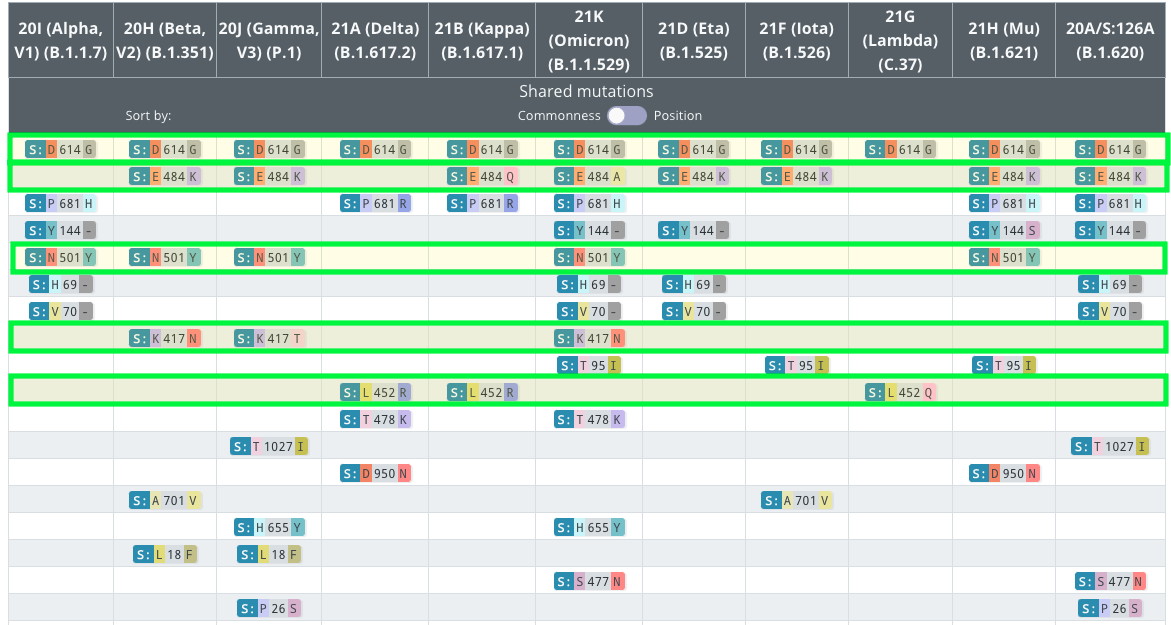